In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
import os
print(os.getcwd())
os.chdir("/Users/IshaanShah/Desktop/weather_data")
print(os.getcwd())

/Users/IshaanShah
/Users/IshaanShah/Desktop/weather_data


In [3]:
df = pd.read_csv("CO_Pollution_Final.csv")
print(df.shape)
print(df.columns)

(2192, 9)
Index(['date_time', 'humidity', 'precipMM', 'pressure', 'tempC',
       'windspeedKmph', 'location', 'CO_Conc', 'weekday'],
      dtype='object')


In [4]:
df['date_time'] = pd.to_datetime(df['date_time'])

## Feature Engineering  
 - Month
 - Is_Weekend
 - Seasons
 - 3-day lag (According to the PACF graph the first 3 lags were the most statistically significant)

In [8]:
df["is_weekend"] = np.where(df["weekday"]=='Saturday',1,np.where(df["weekday"]=='Sunday',1,0))
df[['weekday','is_weekend']]

,weekday,is_weekend
0,Thursday,0
1,Friday,0
2,Saturday,1
3,Sunday,1
4,Monday,0
...,...,...
2187,Sunday,1
2188,Monday,0
2189,Tuesday,0
2190,Wednesday,0


In [9]:
df['month_name'] = df["date_time"].dt.strftime("%B")

In [19]:
conditions = [df[['month_name']].isin (['December','January','February']),
              df[['month_name']].isin (['March','April','May']),
              df[['month_name']].isin (['June','July','August']),
              df[['month_name']].isin (['September','October','November'])]
values = ['Winter','Spring','Summer','Fall']
df['season'] = np.select(conditions,values)

In [21]:
df[['month_name','season']]

,month_name,season
0,January,Winter
1,January,Winter
2,January,Winter
3,January,Winter
4,January,Winter
...,...,...
2187,December,Winter
2188,December,Winter
2189,December,Winter
2190,December,Winter


In [30]:
df['1_Day_Lag'] = df["CO_Conc"].shift(1)
df['2_Day_Lag'] = df["CO_Conc"].shift(2)
df['3_Day_Lag'] = df["CO_Conc"].shift(3)
df.dropna(inplace = True)
df.drop(['location'], axis = 1, inplace = True)
df.head()

,date_time,humidity,precipMM,pressure,tempC,windspeedKmph,CO_Conc,weekday,is_weekend,month_name,season,1_Day_Lag,2_Day_Lag,3_Day_Lag
9,2015-01-10,45,0.1,1015,15,6,0.845946,Saturday,1,January,Winter,0.961429,1.007042,0.978571
10,2015-01-11,72,17.6,1018,11,10,0.683784,Sunday,1,January,Winter,0.845946,0.961429,1.007042
11,2015-01-12,67,0.0,1020,14,11,0.715068,Monday,0,January,Winter,0.683784,0.845946,0.961429
12,2015-01-13,51,0.0,1021,13,8,0.694286,Tuesday,0,January,Winter,0.715068,0.683784,0.845946
13,2015-01-14,39,0.0,1023,12,5,0.688732,Wednesday,0,January,Winter,0.694286,0.715068,0.683784


In [39]:
df.drop(['weekday'], axis = 1, inplace = True) #removing due to high correlation with is_weekend
df.drop(['month_name'], axis = 1, inplace = True) #high correlation with season

In [40]:
df.head()

,date_time,humidity,precipMM,pressure,tempC,windspeedKmph,CO_Conc,is_weekend,season,1_Day_Lag,2_Day_Lag,3_Day_Lag
9,2015-01-10,45,0.1,1015,15,6,0.845946,1,Winter,0.961429,1.007042,0.978571
10,2015-01-11,72,17.6,1018,11,10,0.683784,1,Winter,0.845946,0.961429,1.007042
11,2015-01-12,67,0.0,1020,14,11,0.715068,0,Winter,0.683784,0.845946,0.961429
12,2015-01-13,51,0.0,1021,13,8,0.694286,0,Winter,0.715068,0.683784,0.845946
13,2015-01-14,39,0.0,1023,12,5,0.688732,0,Winter,0.694286,0.715068,0.683784


In [42]:
df = pd.get_dummies(df)
df.set_index('date_time', inplace = True)
df.head()

,humidity,precipMM,pressure,tempC,windspeedKmph,CO_Conc,is_weekend,1_Day_Lag,2_Day_Lag,3_Day_Lag,season_Fall,season_Spring,season_Summer,season_Winter
date_time,,,,,,,,,,,,,,
2015-01-10,45,0.1,1015,15,6,0.845946,1,0.961429,1.007042,0.978571,0,0,0,1
2015-01-11,72,17.6,1018,11,10,0.683784,1,0.845946,0.961429,1.007042,0,0,0,1
2015-01-12,67,0.0,1020,14,11,0.715068,0,0.683784,0.845946,0.961429,0,0,0,1
2015-01-13,51,0.0,1021,13,8,0.694286,0,0.715068,0.683784,0.845946,0,0,0,1
2015-01-14,39,0.0,1023,12,5,0.688732,0,0.694286,0.715068,0.683784,0,0,0,1


## Using a SVR

### Train Test Split

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[["humidity","precipMM","pressure","tempC","windspeedKmph","1_Day_Lag","2_Day_Lag","3_Day_Lag","CO_Conc"]] = scaler.fit_transform(df[["humidity","precipMM","pressure","tempC","windspeedKmph","1_Day_Lag","2_Day_Lag","3_Day_Lag","CO_Conc"]])
y = df[["CO_Conc"]]
X = df.drop('CO_Conc', axis = 1)
print(X.shape)
print(y.shape)

(2183, 13)
(2183, 1)


In [63]:
X_train = X[:1746]
y_train = y[:1746]

X_test = X[-437:]
y_test = y[-437:]


In [64]:
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
svr.fit(X_train,y_train.values.ravel())

SVR()

In [65]:
svr.score(X_train,y_train.values.ravel())

0.934327470783035

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r
print("MSE : ", mean_squared_error(y_train.values.ravel(), svr.predict(X_train)))
print("MAE : ", mean_absolute_error(y_train.values.ravel(), svr.predict(X_train)))

MSE :  0.06035149513636988
MAE :  0.1707567779085118


In [80]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [87]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1,1.0,5.0,10.0,100.0],'gamma': ('scale','auto')}
svr_grid = GridSearchCV(estimator = svr, param_grid = param_grid,
                               cv = 5, verbose=3, n_jobs = -1)
svr_grid.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1.0, 5.0, 10.0, 100.0],
                         'gamma': ('scale', 'auto')},
             verbose=3)

In [88]:
print(svr_grid.best_params_)
best_svr = svr_grid.best_estimator_
best_svr.fit(X_train,y_train.values.ravel())
print("R-sqaured score:",best_svr.score(X_train,y_train.values.ravel()))
print("MSE : ", mean_squared_error(y_train.values.ravel(),best_svr.predict(X_train)))
print("MAE : ", mean_absolute_error(y_train.values.ravel(),best_svr.predict(X_train)))

{'C': 1.0, 'gamma': 'auto'}
R-sqaured score: 0.9282004809411415
MSE :  0.06598205333250687
MAE :  0.1794836486036491


In [99]:
y_pred = best_svr.predict(X_test)
print("R-sqaured score:", best_svr.score(X_test,y_test.values.ravel()))
print("MSE : ", mean_squared_error(y_test,y_pred))
print("MAE : ", mean_absolute_error(y_test,y_pred))

R-sqaured score: 0.8642324118714562
MSE :  0.16964077089781726
MAE :  0.2810642984128271


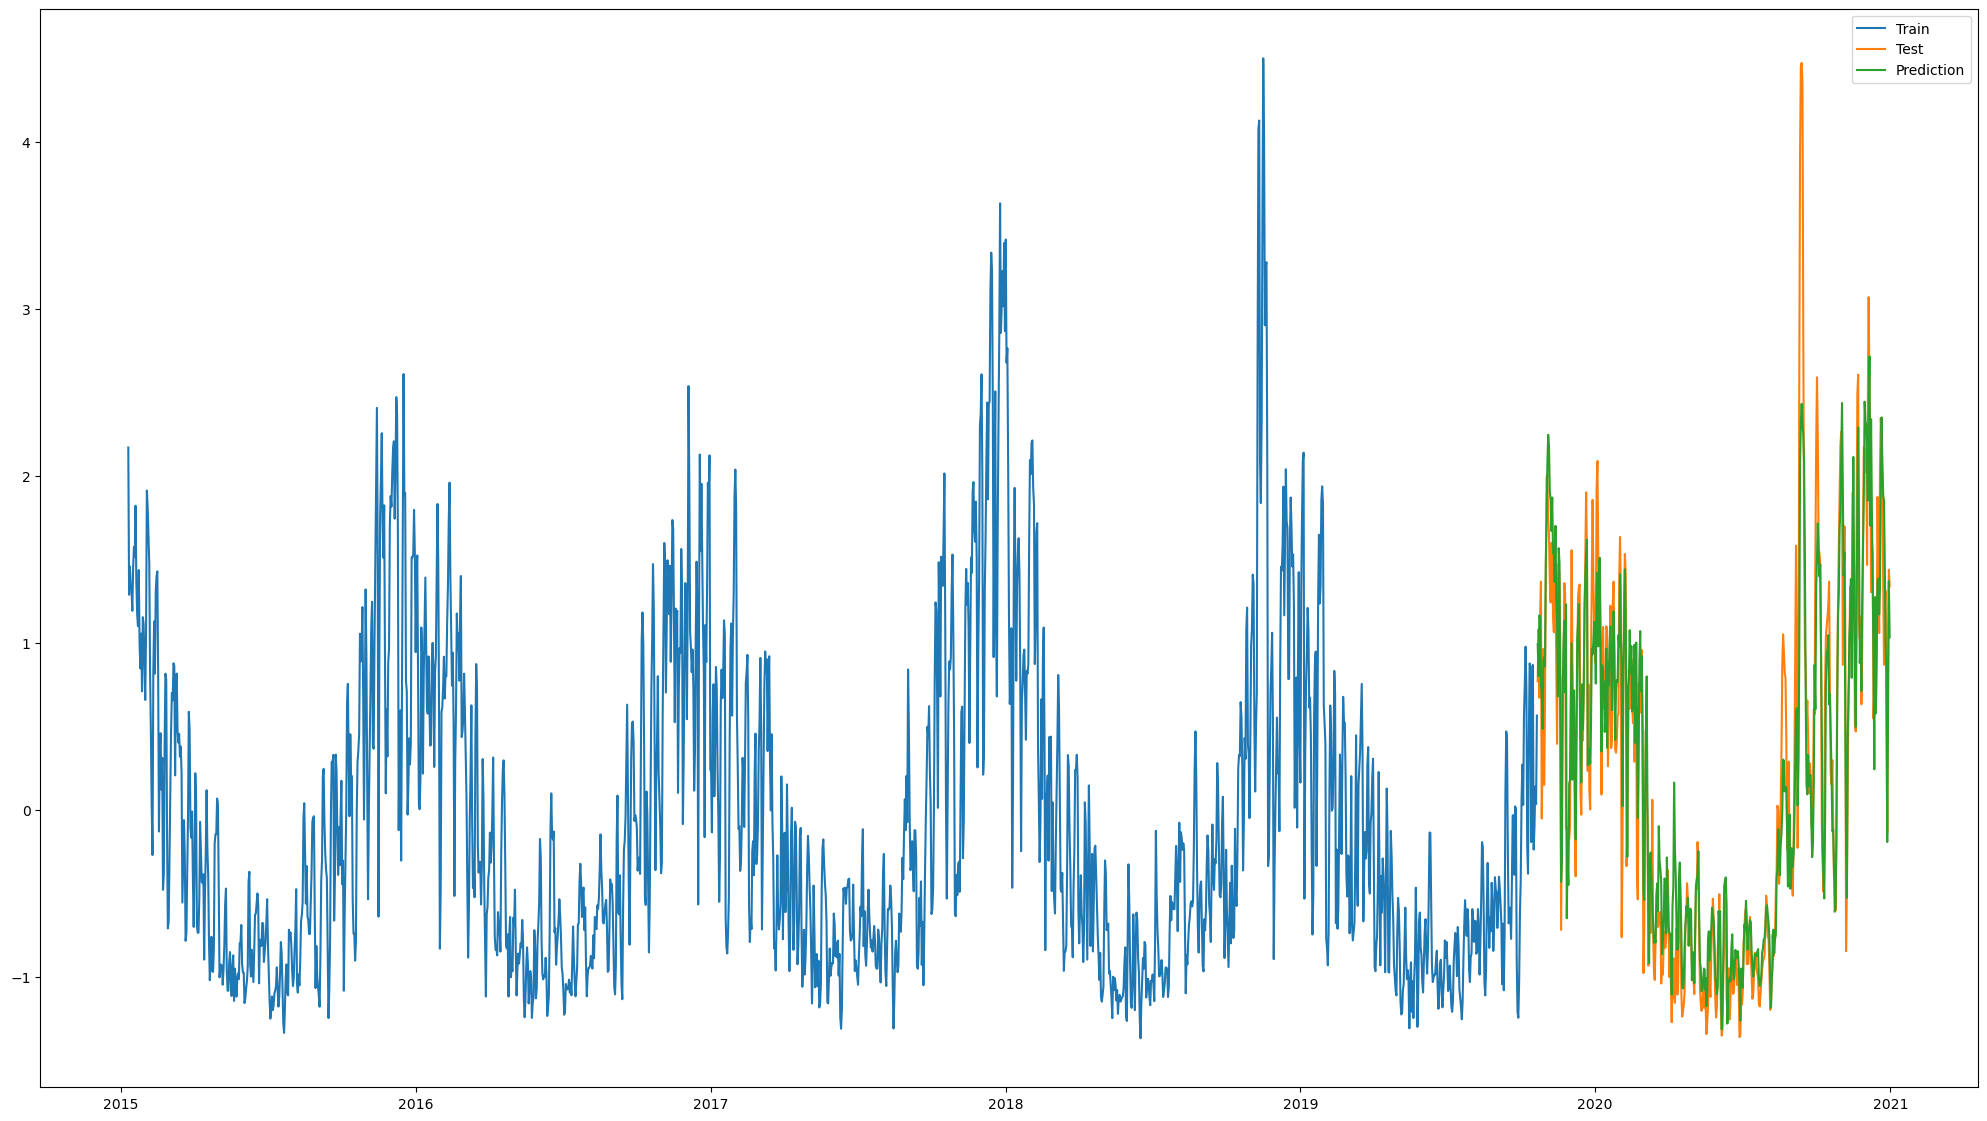

In [104]:
fig = plt.figure(figsize = (25,14))
plt.plot(y_train, label = "Train")
plt.plot(y_test, label = "Test")
y_pred_df = pd.DataFrame(y_pred, index = y_test.index)
plt.plot(y_pred_df, label = "Prediction")
plt.legend()
plt.show()

 The results looks great. Lets try one model without the lag and solely the weather data.

In [159]:
exp = pollution.drop(["1_Day_Lag","2_Day_Lag","3_Day_Lag"], axis = 1)
exp[["humidity","precipMM","pressure","tempC","windspeedKmph","CO_Conc"]] = scaler.fit_transform(exp[["humidity","precipMM","pressure","tempC","windspeedKmph","CO_Conc"]])
y_exp = exp[["CO_Conc"]]
X_exp = exp.drop('CO_Conc', axis = 1)
print(X_exp.shape)
print(y_exp.shape)

(179, 10)
(179, 1)


In [107]:
X_train_exp = X_exp[:1746]
y_train_exp = y_exp[:1746]

X_test_exp = X_exp[-437:]
y_test_exp = y_exp[-437:]

In [108]:
svr_exp = SVR(kernel = 'rbf')
svr_exp.fit(X_2021,y_2021())

SVR()

In [115]:
svr_exp.score(X_train_exp,y_train_exp.values.ravel())

0.786147549391551

Pretty good values on the training set, lets test these models now

Using no test set to see if COVID-19 had any impact on pollutant levels in 2021

In [116]:
svr_full = SVR(kernel = 'rbf')
svr_full.fit(X,y.values.ravel())
print("R-sqaured score:",svr_full.score(X,y.values.ravel()))
print("MSE : ", mean_squared_error(y.values.ravel(),svr_full.predict(X)))
print("MAE : ", mean_absolute_error(y.values.ravel(),svr_full.predict(X)))

R-sqaured score: 0.9321493454181619
MSE :  0.0678506545818381
MAE :  0.18056757919340752


Importing 2021 CO data

In [141]:
pollution_2021 = pd.read_csv("CO_2021.csv")
weather_2021 = pd.read_csv('california.csv')

In [142]:
pollution_2021 = pollution_2021[["Date","Daily Max 8-hour CO Concentration"]]
pollution_2021["Date"] = pd.to_datetime(pollution_2021["Date"])
pollution_clean = pollution_2021.groupby(pollution_2021["Date"]).mean("Daily Max 8-hour CO Concentration").reset_index()
pollution_clean.head()

,Date,Daily Max 8-hour CO Concentration
0,2021-01-01,0.650000
1,2021-01-02,0.626316
2,2021-01-03,0.628070
3,2021-01-04,0.640351
4,2021-01-05,0.666667


In [143]:
cols_to_drop = ["totalSnow_cm","uvIndex","sunHour","moon_illumination","moonrise","moonset","sunrise","sunset","DewPointC",
                "FeelsLikeC","HeatIndexC","WindChillC","cloudcover","WindGustKmph","visibility","winddirDegree",
                "mintempC","maxtempC",'location']
weather_clean = weather_2021.drop(cols_to_drop, axis = 1)
weather_clean.head()

,date_time,humidity,precipMM,pressure,tempC,windspeedKmph
0,2021-01-01,38,0.0,1020,11,7
1,2021-01-02,39,0.0,1023,12,6
2,2021-01-03,62,0.0,1022,13,5
3,2021-01-04,59,0.0,1019,16,10
4,2021-01-05,60,0.0,1020,15,9


In [144]:
weather_clean['date_time'] = pd.to_datetime(weather_clean['date_time'])
pollution = pd.merge(weather_clean,pollution_clean, left_on = "date_time", right_on = "Date", how = "right").drop('Date', axis = 1)
pollution["CO_Conc"] = pollution['Daily Max 8-hour CO Concentration']
pollution = pollution.drop('Daily Max 8-hour CO Concentration', axis = 1)
pollution.head()

,date_time,humidity,precipMM,pressure,tempC,windspeedKmph,CO_Conc
0,2021-01-01,38,0.0,1020,11,7,0.650000
1,2021-01-02,39,0.0,1023,12,6,0.626316
2,2021-01-03,62,0.0,1022,13,5,0.628070
3,2021-01-04,59,0.0,1019,16,10,0.640351
4,2021-01-05,60,0.0,1020,15,9,0.666667


In [145]:
pollution["weekday"] = pollution["date_time"].dt.strftime("%A")
pollution["is_weekend"] = np.where(pollution["weekday"]=='Saturday',1,np.where(pollution["weekday"]=='Sunday',1,0))
pollution['month_name'] = pollution["date_time"].dt.strftime("%B")
conditions = [pollution[['month_name']].isin (['December','January','February']),
              pollution[['month_name']].isin (['March','April','May']),
              pollution[['month_name']].isin (['June','July','August']),
              pollution[['month_name']].isin (['September','October','November'])]
values = ['Winter','Spring','Summer','Fall']
pollution['season'] = np.select(conditions,values)
pollution['1_Day_Lag'] = pollution["CO_Conc"].shift(1)
pollution['2_Day_Lag'] = pollution["CO_Conc"].shift(2)
pollution['3_Day_Lag'] = pollution["CO_Conc"].shift(3)
pollution.dropna(inplace = True)
pollution.drop(['weekday'], axis = 1, inplace = True) 
pollution.drop(['month_name'], axis = 1, inplace = True)
pollution.head()

,date_time,humidity,precipMM,pressure,tempC,windspeedKmph,CO_Conc,is_weekend,season,1_Day_Lag,2_Day_Lag,3_Day_Lag
3,2021-01-04,59,0.0,1019,16,10,0.640351,0,Winter,0.628070,0.626316,0.650000
4,2021-01-05,60,0.0,1020,15,9,0.666667,0,Winter,0.640351,0.628070,0.626316
5,2021-01-06,37,0.0,1021,15,5,0.773214,0,Winter,0.666667,0.640351,0.628070
6,2021-01-07,32,0.0,1021,15,3,0.749123,0,Winter,0.773214,0.666667,0.640351
7,2021-01-08,37,0.0,1020,16,10,0.739286,0,Winter,0.749123,0.773214,0.666667


In [146]:
pollution = pd.get_dummies(pollution)
pollution["season_Fall"] = 0 #Doing this manually as there was no Fall in 2021 yet
pollution.set_index('date_time', inplace = True)
pollution[["humidity","precipMM","pressure","tempC","windspeedKmph","1_Day_Lag","2_Day_Lag","3_Day_Lag","CO_Conc"]] = scaler.fit_transform(pollution[["humidity","precipMM","pressure","tempC","windspeedKmph","1_Day_Lag","2_Day_Lag","3_Day_Lag","CO_Conc"]])
y_2021 = pollution[["CO_Conc"]]
X_2021 = pollution.drop('CO_Conc', axis = 1)
print(X_2021.shape)
print(y_2021.shape)

(179, 13)
(179, 1)


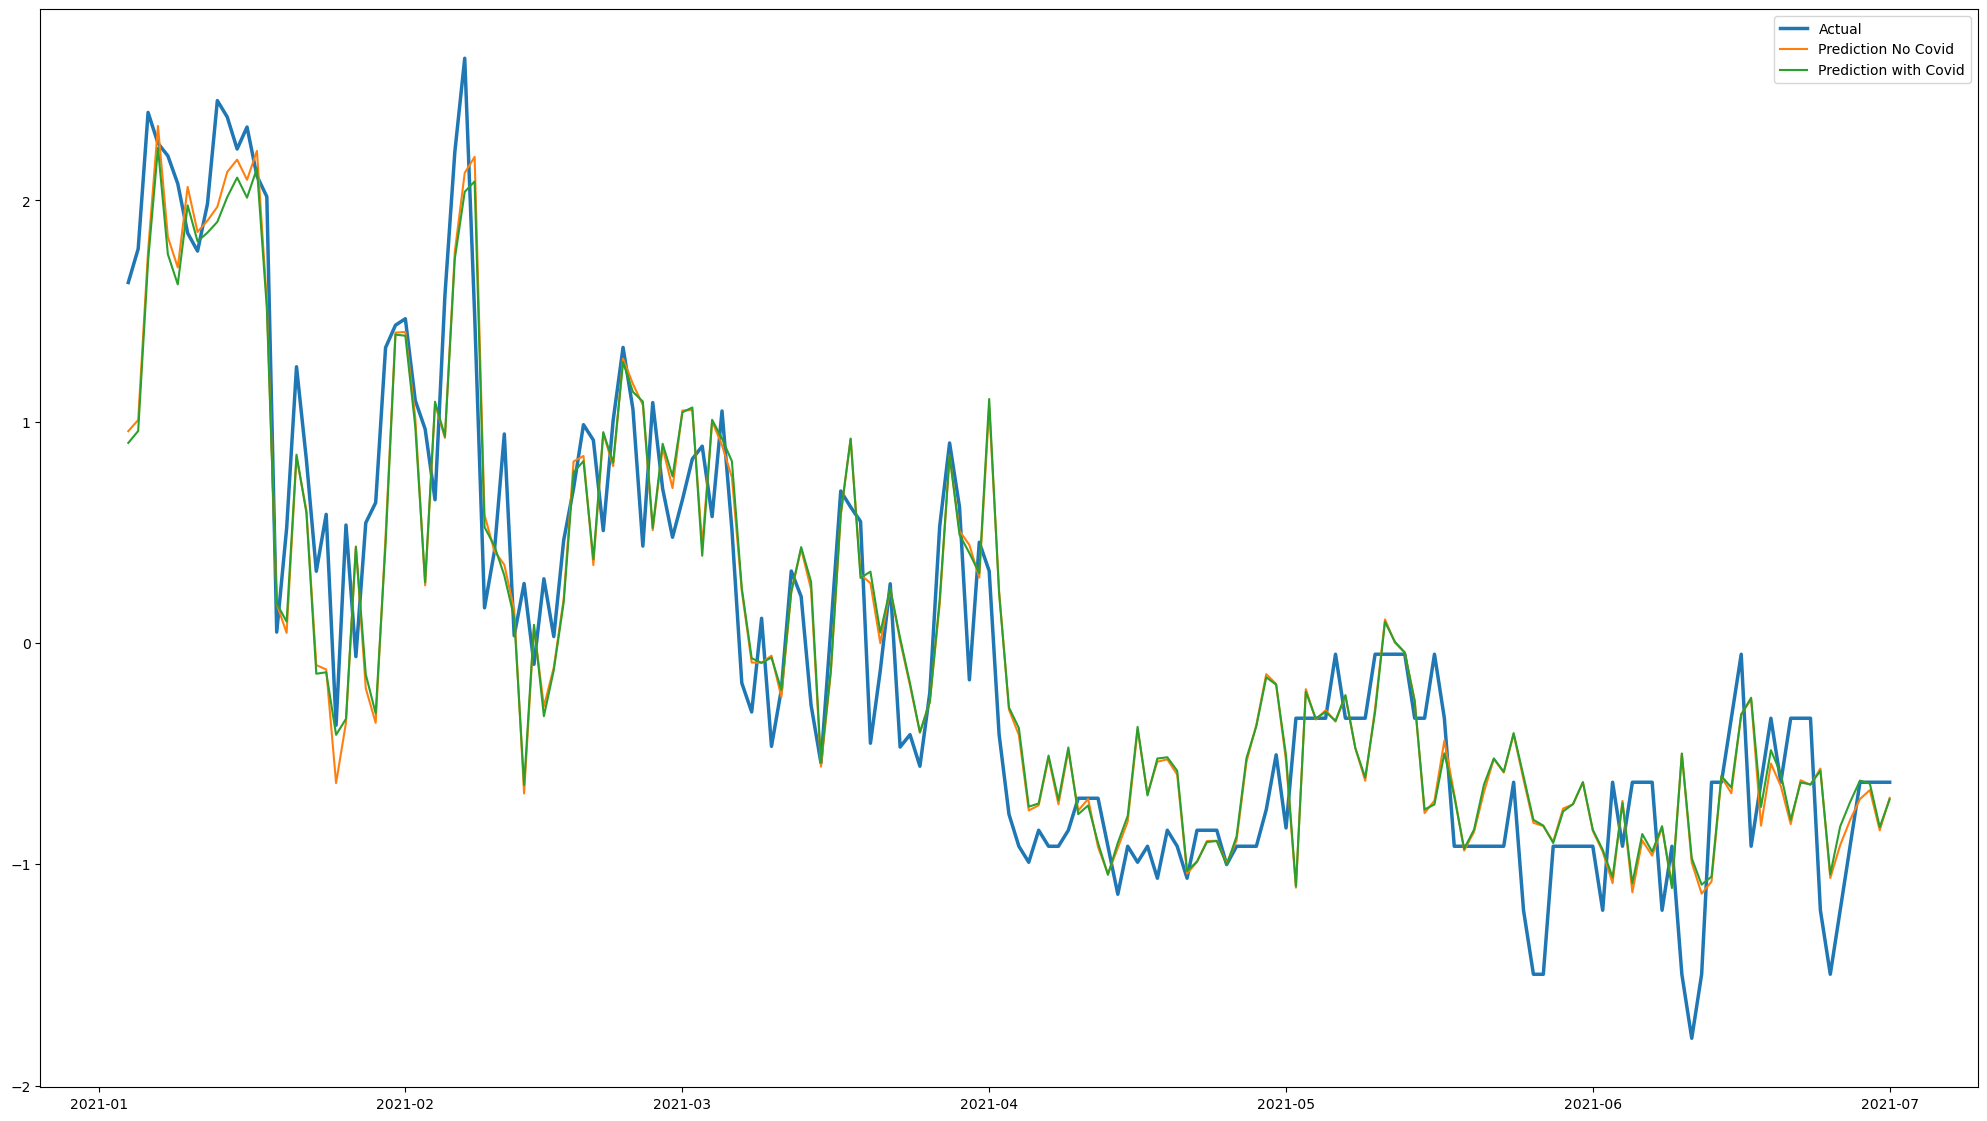

In [171]:
fig = plt.figure(figsize = (25,14))
plt.plot(y_2021, label = "Actual", linewidth = 2.5)
y_pred_no_covid = best_svr.predict(X_2021)
y_pred_no_covid = pd.DataFrame(y_pred_no_covid, index = y_2021.index)
plt.plot(y_pred_no_covid, label = "Prediction No Covid")
y_pred_covid = svr_full.predict(X_2021)
y_pred_covid = pd.DataFrame(y_pred_covid, index = y_2021.index)
plt.plot(y_pred_covid, label = "Prediction with Covid")
plt.legend()
plt.show()

In [150]:
print("R-sqaured score:",svr_full.score(X_2021,y_2021.values.ravel()))
print("MSE : ", mean_squared_error(y_2021.values.ravel(),svr_full.predict(X_2021)))
print("MAE : ", mean_absolute_error(y_2021.values.ravel(),svr_full.predict(X_2021)))

R-sqaured score: 0.8432720519640982
MSE :  0.15672794803590182
MAE :  0.31605131930945046


In [151]:
print("R-sqaured score:",best_svr.score(X_2021,y_2021.values.ravel()))
print("MSE : ", mean_squared_error(y_2021.values.ravel(),best_svr.predict(X_2021)))
print("MAE : ", mean_absolute_error(y_2021.values.ravel(),best_svr.predict(X_2021)))

R-sqaured score: 0.8471916405499441
MSE :  0.15280835945005586
MAE :  0.31226671453682325


The results with and without the COVID year for 2021 look almost identical. The Support Vector Regression model seems great at prediciting CO concentration in Califonia